<a href="https://colab.research.google.com/github/kogby/DA_KKTV/blob/neo_branch/%E5%98%97%E8%A9%A6%E4%B8%8D%E5%90%8Cduration_conversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 套件環境

In [6]:
import os
from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/Colab/資料分析期末') #切換該目錄
os.listdir() #確認目錄內容

Mounted at /content/drive


['嘗試不同duration_conversion.ipynb',
 'data',
 'models',
 'preprocessed_output',
 'large0520.ipynb',
 '過往東東',
 '0521KKTV (light).ipynb',
 'submit.csv',
 '0528model.ipynb']

In [7]:
# always needed
import math, os, random, csv
import pandas as pd
import numpy as np

# log and save
import json, logging, pickle, sys, shutil, copy
# torch
import torch
import torch.nn
from torch.nn import Conv2d, MaxPool2d, Flatten, Linear, ReLU
import torchvision
from tqdm.auto import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader,ConcatDataset
from torchvision import datasets, models, transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler

# For plotting learning curve
from torch.utils.tensorboard import SummaryWriter
%matplotlib inline
import seaborn as sns

# others
import matplotlib.pyplot as plt
from PIL import Image

# sklearn
from sklearn import preprocessing

# statistics
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statistics

# seeds
def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


### 查看原始duration分佈

In [9]:
ori = np.load('./preprocessed_output/duration_data_origin.npy')

In [10]:
ori = ori.flatten()
ori.shape

(31556560,)

In [11]:
filtered_values = ori[(ori >= 1) & (ori <= 30000)]

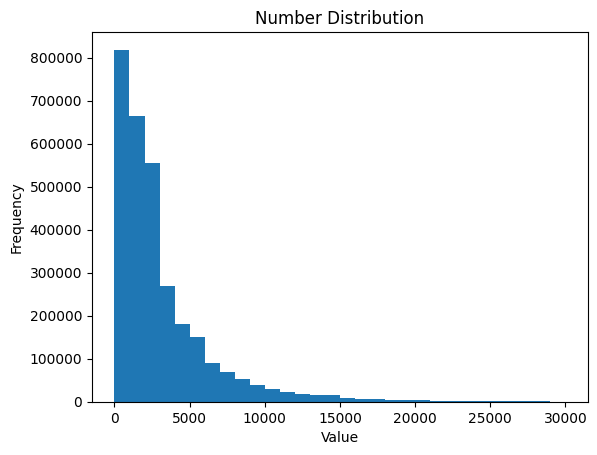

In [12]:
plt.hist(filtered_values, bins=30)  # Adjust the number of bins as needed
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Number Distribution')
plt.show()

## 正文

### Conversion Function

In [13]:
60**(0.3) / (28800**0.2)

0.43809356856576737

In [14]:
# k = 0.15
# def modify_long(n):
#     m = n**(k) / (28800**k)
#     return max(0, min(1, m))
# def modify_short(n):
#     m = n**(k) / (14400**k)
#     return max(0, min(1, m))

In [26]:
k = 0.33
kk = 0.23
def modify_long(n):
    m = n**(k) / (28800**kk)
    return max(0, min(1, m))
def modify_short(n):
    m = n**(k) / (14400**kk)
    return max(0, min(1, m))

### test source

In [27]:
duration_mtx = np.load('./preprocessed_output/test_duration_data_origin.npy')
short_slot = (np.arange(2, duration_mtx.shape[1], 4).reshape(-1, 1) + np.arange(2)).flatten()
long_slot = (np.arange(0, duration_mtx.shape[1], 4).reshape(-1, 1) + np.arange(2)).flatten()

for i, data in enumerate(duration_mtx):
    for idx in short_slot:
        duration_mtx[i][idx] = modify_short(duration_mtx[i][idx])
    for idx in long_slot:
        duration_mtx[i][idx] = modify_long(duration_mtx[i][idx])
np.save('./preprocessed_output/test_duration_data_scaled.npy', duration_mtx)

### train source

In [28]:
duration_mtx = np.load('./preprocessed_output/duration_data_origin.npy')
short_slot = (np.arange(2, duration_mtx.shape[1], 4).reshape(-1, 1) + np.arange(2)).flatten()
long_slot = (np.arange(0, duration_mtx.shape[1], 4).reshape(-1, 1) + np.arange(2)).flatten()

for i, data in enumerate(duration_mtx):
    for idx in short_slot:
        duration_mtx[i][idx] = modify_short(duration_mtx[i][idx])
    for idx in long_slot:
        duration_mtx[i][idx] = modify_long(duration_mtx[i][idx])
np.save('./preprocessed_output/duration_data_scaled.npy', duration_mtx)

### train target

In [29]:
duration_mtx = np.load('./preprocessed_output/train_target_duration_origin.npy')
short_slot = (np.arange(2, duration_mtx.shape[1], 4).reshape(-1, 1) + np.arange(2)).flatten()
long_slot = (np.arange(0, duration_mtx.shape[1], 4).reshape(-1, 1) + np.arange(2)).flatten()
for i, data in enumerate(duration_mtx):
    for idx in short_slot:
        duration_mtx[i][idx] = modify_short(duration_mtx[i][idx])
    for idx in long_slot:
        duration_mtx[i][idx] = modify_long(duration_mtx[i][idx])
        
np.save('./preprocessed_output/train_duration_target.npy', duration_mtx)

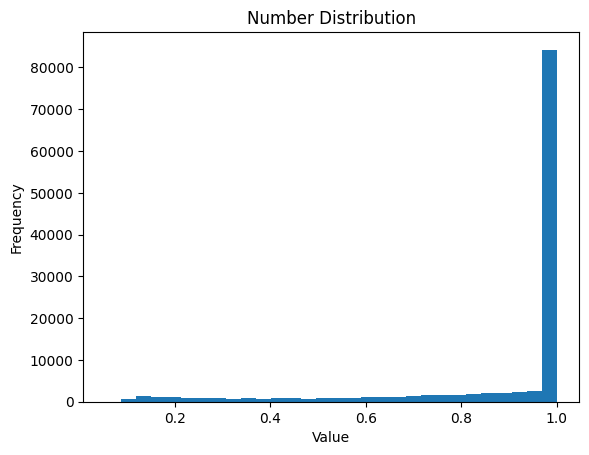

In [30]:
ori = duration_mtx.flatten()
filtered_values = ori[(ori >= 0.001) & (ori <= 30000)]
plt.hist(filtered_values, bins=30)  # Adjust the number of bins as needed
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Number Distribution')
plt.show()

In [25]:
# df = pd.read_csv("./data/train_target_events.csv")
# df['event_time'] = pd.to_datetime(df['event_time'], unit='s')
# start_date = pd.to_datetime('2022-09-17')
# end_date = pd.to_datetime('2022-09-24')

# num_weeks = (end_date - start_date).days / 7
# amount_ppl = len(df['user_id'].unique())
# time_slots = []
# for i in range(7):
#     # 01:00-09:00
#     start_slot = start_date + pd.DateOffset(hours=i*24) + pd.DateOffset(hours=1)
#     end_slot = start_date + pd.DateOffset(hours=i*24) + pd.DateOffset(hours=9)
#     time_slots.append((start_slot, end_slot))
    
#     # 09:00-17:00
#     start_slot = start_date + pd.DateOffset(hours=i*24) + pd.DateOffset(hours=9)
#     end_slot = start_date + pd.DateOffset(hours=i*24) + pd.DateOffset(hours=17)
#     time_slots.append((start_slot, end_slot))
    
#     # 17:00-21:00
#     start_slot = start_date + pd.DateOffset(hours=i*24) + pd.DateOffset(hours=17)
#     end_slot = start_date + pd.DateOffset(hours=i*24) + pd.DateOffset(hours=21)
#     time_slots.append((start_slot, end_slot))
    
#     # 21:00 to next day 01:00
#     start_slot = start_date + pd.DateOffset(hours=i*24) + pd.DateOffset(hours=21)
#     end_slot = start_date + pd.DateOffset(hours=(i+1)*24) + pd.DateOffset(hours=1)
#     time_slots.append((start_slot, end_slot))

# num_slots = 28
# duration_mtx = np.zeros((amount_ppl, num_slots))
# for current_slot_index, slot in enumerate(time_slots): #走過全部的slot
    
#     start_slot = slot[0]
#     end_slot = slot[1]
    
#     #if(current_slot_index == 2) : break
#     print(f'slot_start: {start_slot}, slot_end: {end_slot}')

#     slot_df = df[(df['event_time'] >= start_slot) & (df['event_time'] <= end_slot)] #所有屬於這個slot的data

#     for idx, row in slot_df.iterrows(): #每個row代表這個slot的其中一筆user的使用資料
#         user_id = row['user_id']
#         duration = float(row['played_duration'])
#         current_time = row['event_time']

#         '''要處理duration時長過多溢出的問題, 理論上每段duration在一個slot最高是3600*8=28800
#             Minimum played_duration: 1,
#             Maximum played_duration: 2065490'''
#         tmp_slot = current_slot_index #這段duration應該要加到user_id的哪一個slot

#         time_diff_seconds = (current_time - start_slot).total_seconds() #從這個slot的起點已經過了多久了到這個event_time
#         minus_value = min(time_diff_seconds, duration)
#         duration_mtx[user_id][tmp_slot] += minus_value
#         duration -= minus_value
#         tmp_slot -= 1 #準備進入之前迴圈
#         while(duration > 0 and tmp_slot >= 0):
#             this_slot_duration = time_slots[tmp_slot][1] - time_slots[tmp_slot][0]
#             minus_value = min(this_slot_duration.total_seconds(), duration) #看是duration剩餘的多還是這個slot總時間
#             duration_mtx[user_id][tmp_slot] += minus_value
#             duration -= minus_value
#             tmp_slot -= 1
# np.save('./preprocessed_output/train_target_duration_origin.npy', duration_mtx)